# Artificial Intelligence
## Classifier
### Clothing

Basic classification: Classify images of clothing.

Classification is the process of predicting the class of given data points. Classes are sometimes called as targets/ labels or categories. Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y).

Said another way...

A classifier in machine learning is an algorithm that automatically orders or categorizes data into one or more of a set of “classes.” The process of categorizing or classifying information based on certain characteristics is known as classification.

For example, spam detection in email service providers can be identified as a classification problem. This is s binary classification since there are only 2 classes as spam and not spam. A classifier utilizes some training data to understand how given input variables relate to the class. In this case, known spam and non-spam emails have to be used as the training data. When the classifier is trained accurately, it can be used to detect an unknown email.

Classification belongs to the category of supervised learning where the targets also provided with the input data. There are many applications in classification in many domains such as in credit approval, medical diagnosis, target marketing etc.


Types of Classifiers:
+ Binary Classifiers: These are used when there are only two possible classes. For example, an email classifier might be designed to detect spam and non-spam emails.
+ Multiclass Classifiers: These handle situations where there are more than two classes. For instance, a classifier that categorizes news articles into topics like sports, politics, and technology.
+ Multilabel Classifiers: These can assign multiple labels to each instance. For example, a movie could be classified into multiple genres like comedy,drama, and action simultaneously.



### Reference:
+ https://www.tensorflow.org/tutorials/keras/classification
+ https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623
+ https://github.com/christophergarthwood/jbooks/blob/main/ML-000-d_KerasTensorFlowGPU.ipynb

In [1]:
BUCKET_NAME       = "cio-training-vertex-colab"
PROJECT_ID        = "ai-bootcamp-oct-2024"
LOCATION          = "us-central1"
secret_name       = "ai-training-key-secret"
secret_version    = "latest"
secret_project_id = "usfs-tf-admin"
resource_name     = f"projects/{secret_project_id}/secrets/{secret_name}/versions/{secret_version}"

## Environment Check

In [2]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")

You are running this notebook in Google Colab.


## Library Management

In [3]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
import tensorflow as tf
from tensorflow import keras

import glob
import imageio
import matplotlib as matplt
import os
import PIL
import time

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

warnings.filterwarnings('ignore')               # don't print out warnings

############################################
# ML Libs
############################################
# TensorFlow and tf.keras
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


## Variables

In [4]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLCLASSIFIER"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256
BOLD_START = "\033[1m"
BOLD_END = "\033[0;0m"

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [5]:
## Outputs library version history of effort.
#
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=40
    package_version_length=20

    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             print(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        print(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        print(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        print(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        print(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        print(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        print(f"{'     count':<40}#: {torch.cuda.device_count()}")
        print(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass
    return

## Function Call

In [6]:
lib_diagnostics()

nltk                                    #: 3.8.1               
numpy                                   #: 1.26.4              
pandas                                  #: 2.1.4               
TensorFlow version                      #: 2.17.0              
     gpu.count:                         #: 1
     cpu.count:                         #: 1


## Input Sources

### Load and prepare the dataset

You will use the MNIST dataset to obtain data.

*Note*:
MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.  Reference: https://en.wikipedia.org/wiki/MNIST_database

This example uses the Fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow.

In [7]:
#create reference to dataset
fashion_mnist = keras.datasets.fashion_mnist

#load the data and split into train/test datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
#Train variable details
print("Your training data:")
print("{} shape is {}.".format("Train images ", train_images.shape) )
print("{} shape is {}.".format("Train labels ", train_labels.shape) )
print("{} sample structure is {}".format("Train labels", train_labels))
print("These images and thier corresponding labels represent trusted data to train the model on.")
print("")

#Test variable details
print("Your test data:")
print("{} shape is {}.".format("Test images ", test_images.shape) )
print("{} shape is {}.".format("Test labels ", test_labels.shape) )
print("{} sample structure is {}".format("Test labels", test_labels))
print("These images and thier corresponding labels represent trusted data to test the model on.  How does the model know if it's performing well?")
print("By using the test data per iteration to check itself.")

Your training data:
Train images  shape is (60000, 28, 28).
Train labels  shape is (60000,).
Train labels sample structure is [9 0 0 ... 3 0 5]
These images and thier corresponding labels represent trusted data to train the model on.

Your test data:
Test images  shape is (10000, 28, 28).
Test labels  shape is (10000,).
Test labels sample structure is [9 2 1 ... 8 1 5]
These images and thier corresponding labels represent trusted data to test the model on.  How does the model know if it's performing well?
By using the test data per iteration to check itself.


### Dataset Definition

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label 	Class

+ 0 	T-shirt/top
+ 1 	Trouser
+ 2 	Pullover
+ 3 	Dress
+ 4 	Coat
+ 5 	Sandal
+ 6 	Shirt
+ 7 	Sneaker
+ 8 	Bag
+ 9 	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [9]:
#associate "human legible" labels to the actual dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Example Image from Dataset

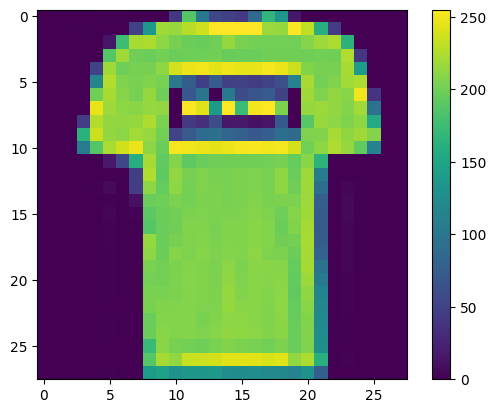

In [10]:
#show the first image from the training dataset
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way.  Ultimately your inference / prediction of data will follow the same method of scaling.

If you don't make your inference inputs align to the same method(s) you used during training, you cannot expect the same level of quality result obtained during training.

In [11]:
#scale the images between 0 - 1
train_images = train_images / 255.0
test_images = test_images / 255.0

## Show Sample Data
Show the first 25 images from the training dataset and display the classification name with each.

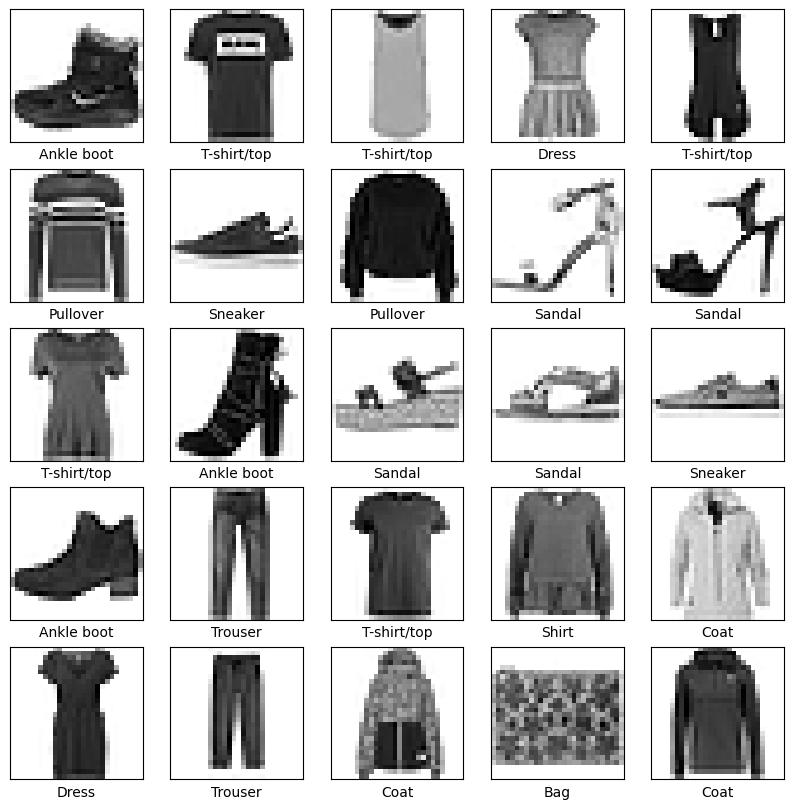

In [12]:
#sneak peek of the data
#Did you notice a difference in the output of the data?  What's the difference between the first image seen and these images?
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Before we start...

*Let's talk about CPU versus GPU.*

A central processing unit (CPU) and a graphics processing unit (GPU) are both essential components of a computer, but they have different functions and architectures:

### CPU

The CPU is the core of a computer's processing system and is responsible for handling all the computing tasks that allow the operating system and applications to run. CPUs are often referred to as the "brain" of the computer and are well suited to a wide range of tasks.

### GPU

The GPU is a more specialized component that is designed to process images and accelerate the rendering of 3D computer graphics. GPUs are well suited to tasks that involve complex mathematical operations that can be run in parallel, such as machine learning, video editing, and gaming.

Here are some other differences between CPUs and GPUs:
+ Processing: CPUs process data sequentially, while GPUs process data in parallel.
+ Architecture: CPUs are made up of billions of transistors, while GPUs are made up of many smaller and more specialized cores.
+ Purpose: CPUs are essential to all modern computing systems, while GPUs are more specialized in nature.

***If the only thing you remember is this then you're okay...ALWAYS try to utilize the GPU and make sure you're actually using it.***

In [13]:
#################################
# - Setup some basic timers material
#################################
from time import perf_counter

## Let's see what we've got...

In [14]:
print(f"{BOLD_START}List Devices{BOLD_END} #########################################")
try:
  from tensorflow.python.client import device_lib
  print(device_lib.list_local_devices())
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

print(f"{BOLD_START}Devices Counts{BOLD_END} ########################################")
try:
  print(f"Num GPUs Available: {str(len(tf.config.experimental.list_physical_devices('GPU')))}" )
  print(f"Num CPUs Available: {str(len(tf.config.experimental.list_physical_devices('CPU')))}" )
  print("")
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

print(f"{BOLD_START}Optional Enablement{BOLD_END} ####################################")
try:
  gpus = tf.config.experimental.list_physical_devices('GPU')
except RuntimeError as e:
  # Visible devices must be set before GPUs have been initialized
  print(str(repr(e)))

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print( str( str(len(gpus)) + " Physical GPUs," + str(len(logical_gpus)) + " Logical GPU") )
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(str(repr(e)))
  print("")

List Devices #########################################
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5194979711374593580
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5707137024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8312194171424245904
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]

Devices Counts ########################################
Num GPUs Available: 1
Num CPUs Available: 1

Optional Enablement ####################################
1 Physical GPUs,1 Logical GPU



## Set logging constructs and use the OS environment to control access to hardware

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '10'

#To disable GPU access to the current runtime enable -1 for "no GPUs"
#confirmed to work on the Command Line Interface (CLI) of all systems but this one...

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Now Train on CPU only

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them.

Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

Rectified linear unit (ReLU), is an activation function which means, this is how the neuron determines if it's going to fire (weighting of probabilities). See: https://en.wikipedia.org/wiki/Rectifier_(neural_networks) The short version is that ReLU is considered an excellent tool and using a vanishing gradient to determine probabilities always making sure any value less than zero is set to 0.

Your output layer must equal the number of questions you're seeking to ask.  In this case we have ten (10) categories of clothing so we need 10 neurons to represent those different potential answers.

Notice that the "shape" of the first layer corresponds to the shape of the input image.

In [16]:
#given the images and labels begin learning from the train_* dataset for 10 "iterations".
#note that you are ACTIVELY training a neural layer (AI) solution now.

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '10'
start_t=perf_counter()

try:
  with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):

    #DESIGN/BUILD
    #capture the function calls return into a variable, this encapsulate a complex object that defines the entire neural model
    model = keras.Sequential([
        #one-D array are preferred for all processing
        #The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array
        #(of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels
        #in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
        keras.layers.Flatten(input_shape=(28, 28)),

        #first layer is 128 neurons and a ReLU activation function.
        keras.layers.Dense(128, activation='relu'),

        #output layer defined
        keras.layers.Dense(10)
    ])

    #COMPILE
    model.compile(optimizer='adam',
              #v2.1 accepts this activation method but previous versions DO NOT
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    #FIT/TRAIN
    model.fit(train_images, train_labels, epochs=10)
except RuntimeError as e:
  print(str(repr(e)))


end_t=perf_counter()
print(f"Elapsed time: {end_t - start_t}")



Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7834 - loss: 0.6257
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8609 - loss: 0.3831
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8781 - loss: 0.3392
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8846 - loss: 0.3152
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8925 - loss: 0.2922
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8978 - loss: 0.2786
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9001 - loss: 0.2717
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9031 - loss: 0.2591
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9093 - loss: 0.2451
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9112 - loss: 0.2385
Elapsed time: 34.86301487700257


## Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

+ Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

+ Optimizer —This is how the model is updated based on the data it sees and its loss function.

+ Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


## Train the model

### Training the neural network model requires the following steps:

    1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
    2. The model learns to associate images and labels.
    3. You ask the model to make predictions about a test set—in this example, the test_images array.
    4. Verify that the predictions match the labels from the test_labels array.

## Train the model

### Training the neural network model requires the following steps:

    1. Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
    2. The model learns to associate images and labels.
    3. You ask the model to make predictions about a test set—in this example, the test_images array.
    4. Verify that the predictions match the labels from the test_labels array.

## Now Train on GPU only

In [17]:
#given the images and labels begin learning from the train_* dataset for 10 "iterations".
#note that you are ACTIVELY training a neural layer (AI) solution now.

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '10'
start_t=perf_counter()

try:
  with tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):

    #DESIGN/BUILD
    #capture the function calls return into a variable, this encapsulate a complex object that defines the entire neural model
    model = keras.Sequential([
        #one-D array are preferred for all processing
        #The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array
        #(of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels
        #in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
        keras.layers.Flatten(input_shape=(28, 28)),

        #first layer is 128 neurons and a ReLU activation function.
        keras.layers.Dense(128, activation='relu'),

        #output layer defined
        keras.layers.Dense(10)
    ])

    #COMPILE
    model.compile(optimizer='adam',
              #v2.1 accepts this activation method but previous versions DO NOT
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    #FIT/TRAIN
    model.fit(train_images, train_labels, epochs=10)
except RuntimeError as e:
  print(str(repr(e)))


end_t=perf_counter()
print(f"Elapsed time: {end_t - start_t}")



Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7845 - loss: 0.6219
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8632 - loss: 0.3769
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8779 - loss: 0.3330
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8850 - loss: 0.3132
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8909 - loss: 0.2953
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8942 - loss: 0.2827
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9005 - loss: 0.2667
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9056 - loss: 0.2560
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9078 - loss: 0.2469
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9127 - loss: 0.2327
Elapsed time: 29.058989469998778


## Epochs

Notice each epoc completion demonstrates an accuracy improvement.  You can add a *patience* function to drop out when your training reaches an optimal level to avoid overfitting.  Additional *drop out* functions are available as well.

***Ask the instructor what other drop out functions are available.***

## Evaluate accuracy

Now we see how well the model performs.  The `evaluate()` function performs a prediction by taking the test_* inputs and and performing a diff between actual data and predicted data.

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 4ms/step - accuracy: 0.8854 - loss: 0.3268

Test accuracy: 0.8853999972343445


As previously discussed overfitting is a concern.  Notes from the demonstration code:

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

1.  Demonstration of overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting
2.  Strategies to prevent overfitting - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting

## Make Predictions

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

### Logits

The vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

In addition, logits sometimes refer to the element-wise inverse of the sigmoid function. For more information, see tf.nn.sigmoid_cross_entropy_with_logits.

In [19]:
#define another model designed to help identify classes
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

#given the test images what labels have precipitated out?
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [20]:
#let's see what the predictions resulting data structure looks like on the inside.
predictions

#the resultant is an array of arrays [][]
# each row represents each image predicted against
#   each column in each row are the probabilities for each "class"

array([[3.1018996e-07, 1.7484991e-08, 2.1049601e-07, ..., 1.9463330e-03,
        1.4823654e-07, 9.9785101e-01],
       [2.3240797e-04, 1.7837065e-12, 9.9329209e-01, ..., 9.5233842e-19,
        1.8362130e-10, 5.0318278e-13],
       [1.2151405e-07, 9.9999988e-01, 4.3311627e-10, ..., 3.8829209e-20,
        2.5721222e-10, 6.3455778e-17],
       ...,
       [1.7324119e-05, 2.1860569e-11, 1.1741810e-05, ..., 1.4753260e-10,
        9.9995852e-01, 1.2080763e-13],
       [5.4484497e-07, 9.9997926e-01, 3.3219929e-09, ..., 3.8938971e-17,
        4.5495110e-09, 6.5454380e-13],
       [3.2357229e-06, 3.1058804e-07, 3.8553039e-06, ..., 1.3376724e-03,
        6.3017942e-04, 9.2810951e-06]], dtype=float32)

#let's see what the predictions resulting data structure looks like on the inside.

Predictions for the first input (image) submitted.

In [21]:
predictions[0]

array([3.1018996e-07, 1.7484991e-08, 2.1049601e-07, 3.2714547e-14,
       2.5297672e-08, 2.0189214e-04, 7.7382893e-08, 1.9463330e-03,
       1.4823654e-07, 9.9785101e-01], dtype=float32)

In [22]:
#numpy magic, obtain the highest value of the array
the_answer=np.argmax(predictions[0])

#so for the first test image the most likely candidate for a class is element 9 in the array (remember, arrays go from 0..9)
#what does element 9 in the classes array defined earlier represent?  what class?

So, the model is most confident that this image is an ankle boot, or class_names[9]. Examining the test label shows that this classification is correct:

In [23]:
print("Label {} relates to a {}.".format(the_answer,class_names[np.argmax(predictions[0])]))

Label 9 relates to a Ankle boot.


Graph this to look at the full set of 10 class predictions.

In [24]:
#functions defined to show the item and relevance of the prediction

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

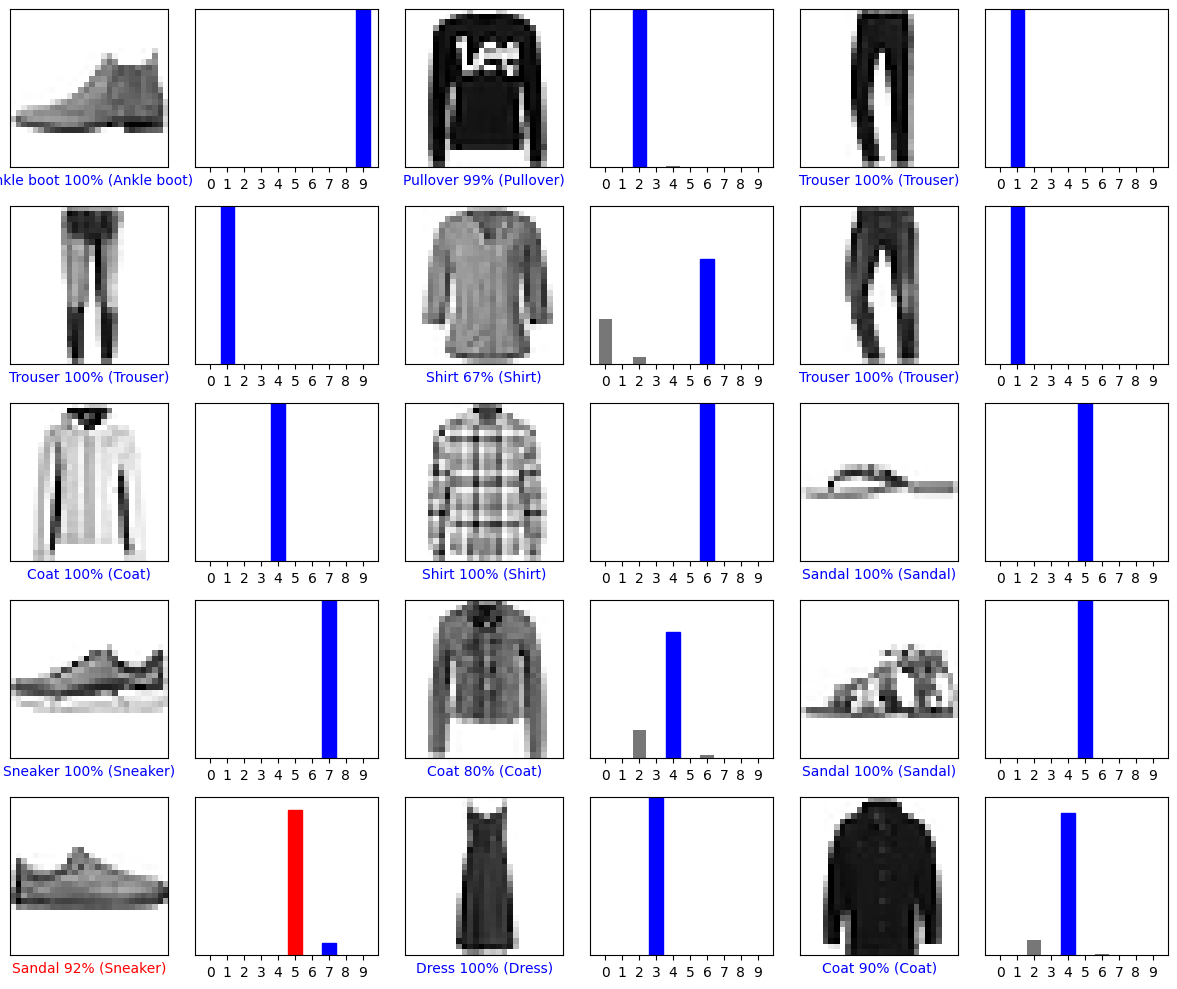

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


## Use the trained model

Use the trained model to make a prediction about a single image.  We will generate a random number selected out of the domain of values.

### *Note*
tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:


In [26]:
# seed the pseudorandom number generator
from random import seed
from random import random

# seed random number generator
seed(1)

#lowest array position
min=0
#highest array position (note that the returned shape is 1000x28x28)
max=test_images.shape[0]-1

#generate a random value
value = random()

#scale that value to the range we have available
scaled_value = min + (value * (max - min))
scaled_value = int(scaled_value)


#take the an image from the test dataset, normally a 28x28 matrix
img = test_images[scaled_value]

# Add the image to a batch where it's the only member, now a 1x28x28 matrix.
img = (np.expand_dims(img,0))

#predict the correct label for this image
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[[3.4198518e-05 2.4664590e-05 8.3202291e-01 5.8640158e-08 1.6385597e-01
  4.6907644e-10 3.9802152e-03 5.9258774e-12 8.2021783e-05 1.3537731e-09]]


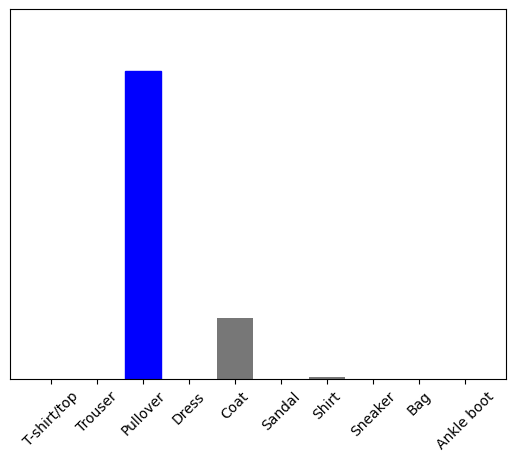

In [27]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [28]:
#keras.Model.predict returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch
np.argmax(predictions_single[0])

2

### Which means...

In [29]:
print("Prediction is label {} which is a {}.".format(np.argmax(predictions_single[0]),class_names[np.argmax(predictions_single[0])]))
print("Reality suggests label {} which is a {}.".format(test_labels[scaled_value],class_names[test_labels[scaled_value]] ))

Prediction is label 2 which is a Pullover.
Reality suggests label 4 which is a Coat.


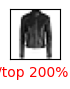

In [30]:
plt.figure(figsize=(1,1))
plot_image(scaled_value,np.argmax(predictions_single[0]), test_labels, test_images)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[6.6816585e-07 2.5470259e-08 1.6574148e-06 8.8802450e-09 7.8911387e-07
  9.9998248e-01 2.8039610e-06 6.9339949e-06 4.3409591e-06 4.0461973e-07]]
Prediction is label 5 which is a Sandal.
Reality suggests label 5 which is a Sandal.


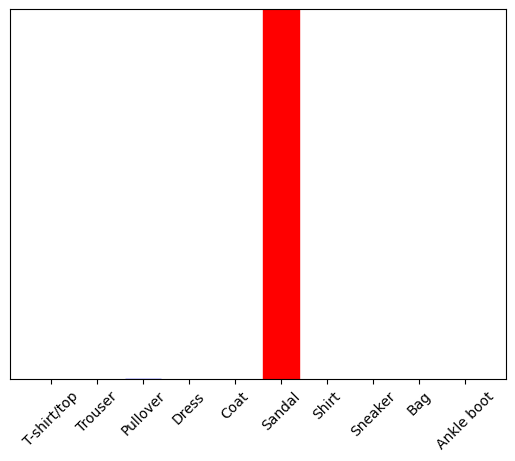

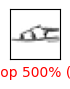

In [31]:
#let's try another one
#generate a random value
value = random()

#scale that value to the range we have available
scaled_value = min + (value * (max - min))
scaled_value = int(scaled_value)
#take the an image from the test dataset, normally a 28x28 matrix
img = test_images[scaled_value]

# Add the image to a batch where it's the only member, now a 1x28x28 matrix.
img = (np.expand_dims(img,0))
#predict the correct label for this image
predictions_single = probability_model.predict(img)

print(predictions_single)
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
np.argmax(predictions_single[0])
print("Prediction is label {} which is a {}.".format(np.argmax(predictions_single[0]),class_names[np.argmax(predictions_single[0])]))
print("Reality suggests label {} which is a {}.".format(test_labels[scaled_value],class_names[test_labels[scaled_value]] ))
plt.figure(figsize=(1,1))
plot_image(scaled_value,np.argmax(predictions_single[0]), test_labels, test_images)
plt.tight_layout()
plt.show()